In [1]:
import time

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib as mpl
matplotlib.use("Agg")
import matplotlib.animation as animation


###Clear this laterr...

/home/matyi/miniconda3/lib/python3.5/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
def makePetriDish(sector_width=10, sectorNr=5, height = 20):

    edges = np.zeros(sector_width)
    for i in range(sectorNr):

        edges  = np.append(edges, np.ones(sector_width)*10**i, 0)
    concentrationMap = np.tile(edges, (height,1))
    return concentrationMap

In [3]:
class bacteria():
    
    def __init__(self,  petriDish, init_strength=0.2,):
        
        ##Base attributes
        self.dish=petriDish
        self.shape= self.dish.shape
        self.bacteriaMap = np.zeros(self.shape)
        self.bacteriaMap[:,0] = init_strength  
        
        ###CHANGE THEESE TWO TO GET OTHER BEHAVIOUR
        self.mu=1
        self.sigma=0.08
        
        ##Attributes for evolving
        self.generation=0
        self.resistance=[]
        self.liveBacMask=np.zeros(self.shape)
        self.liveBacMask[:,0] = 1
        self.ageMap = np.zeros(self.shape)
        self.ageMap[:,0] = 1
        
        ##Attributes for pretty plotting
        self.norm1 = mpl.colors.LogNorm()
        self.colormap1='Blues'   
        self.norm2 = mpl.colors.PowerNorm(gamma=1)
        self.colormap2='flag'
        #best cmap for this : flag, prism
        #'prism' 'rainbow' 'gnuplot' 'jet' 'nipy_spectral' 'flag' 'prism' 'Paired'
        # gamma values: [0.5...2]

        self.ageVideo=[]
        self.fig2=plt.figure()
        self.ax2 = self.fig2.add_subplot(1, 1, 1)      
        
        Writer = animation.writers['ffmpeg']
        self.writer = Writer(fps=20, metadata=dict(artist='John Doe'), bitrate=3600)
        
    def showBacMap(self, cmap='nipy_spectral', pretty=False ):      
        """
        Display the virus' resistance in the petri dish. 
        Try different colormaps and settings
        """
        if pretty:
            prettyMap=np.zeros_like(self.bacteriaMap)
            uniqVals=np.unique(np.sort(self.bacteriaMap.flatten()))
            for index, value in np.ndenumerate(self.bacteriaMap):
                prettyMap[index] = np.where(uniqVals==value)[0]
                
            plt.pcolormesh(prettyMap, cmap=cmap, norm=mpl.colors.LogNorm())
        else:
            plt.pcolormesh(self.bacteriaMap, cmap=self.colormap1, norm=self.norm1)
        
    def showAgeMap(self, cmap='nipy_spectral',  pretty=False):
        """
        Display the agedistribution in the petri dish. 
        Try different colormaps and settings
        """
        if pretty:
            prettyMap=np.zeros_like(self.ageMap)
            uniqVals=np.unique(np.sort(self.ageMap.flatten()))
            for index, value in np.ndenumerate(self.ageMap):
                prettyMap[index] = np.where(uniqVals==value)[0]
                
            plt.pcolormesh(prettyMap, cmap=cmap, norm=mpl.colors.LogNorm())
            
        else:
            plt.pcolormesh(self.ageMap, cmap=self.colormap2, norm=self.norm2)     
        
    def spread (self):
        """
        Spread into nearby emtpy cells based on luck, resistance and antibiotics densitiy.
        """
        newMap = np.empty_like (self.bacteriaMap)
        newMap[:] = self.bacteriaMap
        for (x,y), element in np.ndenumerate(self.bacteriaMap):

            if np.random.rand() > 0.3 and self.bacteriaMap[x,y] == 0 : #and self.bacteriaMap[x,y] > self.dish.concentrationMap[x,y]:
            # if square is not empty and resistance > concentration:
                try: 
                    if self.bacteriaMap[x-1,y] > self.dish[x,y]:
                        newMap[x,y] = self.bacteriaMap[x-1,y]
                except: pass
                try: 
                    if self.bacteriaMap[x+1,y] > self.dish[x,y]:
                        newMap[x,y] = self.bacteriaMap[x+1,y]
                except: pass
                try: 
                    if self.bacteriaMap[x,y+1] > self.dish[x,y]:
                        pass
                        newMap[x,y] = self.bacteriaMap[x,y+1]
                except: pass
                try: 
                    if self.bacteriaMap[x,y-1] > self.dish[x,y]:
                        newMap[x,y] = self.bacteriaMap[x,y-1]
                except: pass
                # I use try to eliminate index out of range errors at the edges
                
        self.bacteriaMap = newMap 
        self.checkStats()      
      
        ##Save current status for saving it as a video later
        #self.resistanceVideo.append((self.ax1.pcolormesh(self.bacteriaMap,
                                         #cmap=self.colormap1, norm=self.norm1),))   
     
    def checkStats(self):
        """Counts new values for visualizaton after every spread() step"""
        newMap = np.empty_like (self.bacteriaMap)
        newMap[:] = self.bacteriaMap
        newMap[np.where(newMap == 0)] = np.nan    
        
        maxval=np.nanmax(newMap)
        minval=np.nanmin(newMap)
        self.norm1 = mpl.colors.LogNorm(vmax=maxval, vmin=minval)
        self.resistance.append( np.nanmean(newMap))

    def evolve(self):
        """
        The resistance value of each sqaure in self.bacteriaMap changes
        randomly, if the square is empty or old (based on self.liveBacMask), the 
        resistance is not updated.
        """
        # mean and standard deviation
        mutationMap = np.random.normal(self.mu, self.sigma, self.shape)
        mutationMap[self.liveBacMask==0]=1
        self.bacteriaMap = self.bacteriaMap * mutationMap
        self.generation+=1       
        
    def age(self):
        """
        Update ageMap after every call, based on ageMap update
        liveBacMask, which is a binary 2D array, controls which cells evolve.
        """
        newMap  = np.empty_like (self.ageMap)
        newMap[:] = self.ageMap
        for (x,y), element in np.ndenumerate(self.ageMap):
            if  self.bacteriaMap[x,y] != 0:
                newMap[x,y] += 1
                
        deathMask=np.zeros(self.shape)
        deathMask[self.ageMap>0]   = 1   # at occupied square bacs should evolve
        deathMask[self.ageMap>400] = 0   # at old square bacs sould not evolve
        
        ### 1 where there's a living bacteria
        self.liveBacMask=deathMask
        self.ageMap=newMap
        
        self.ageVideo.append((self.ax2.pcolormesh(self.ageMap,
                                         cmap='Blues'),))
        
    def onlineSpreading(self, steps=100):
        """
        See the spreading virus in animation, useful
        at early steps too see the effect of different parameters.
        """        
        figOnline,ax = plt.subplots()
        for f in range(steps):
            self.evolve()
            self.spread()
            self.age()
            ax.pcolormesh(self.bacteriaMap, cmap=self.colormap1, norm=self.norm1)
            figOnline.canvas.draw()
            time.sleep(0.1)
            
    def saveVideo(self):
        """
        Save the bacMap (whcih contains resistance values) or ageMap 
        (whcih contains age information) into mp4 file. ffmpeg installation needed.
        Uninstall matplotlib, install ffmpeg, and reinstall matplotlib,
        """

        dpi = 80
        width = 16
        height = 9 ## res = dpi*width*height
        #self.fig1.set_size_inches(width, height, True)
        
        
        self.fig2.set_size_inches(width, height, True)
        
        #resVid = animation.ArtistAnimation(self.fig1, self.resistanceVideo, interval=500, repeat_delay=3000,
        #                           blit=True)
        #resVid.save('simul_resist%d.mp4' %self.generation, writer=self.writer, dpi=dpi)

        ageVid = animation.ArtistAnimation(self.fig2, self.ageVideo, interval=500, repeat_delay=3000,
                                   blit=True)
        ageVid.save('simul_ages%d.mp4' %self.generation, writer=self.writer, dpi=dpi)

In [4]:
petriD = makePetriDish(25,4,80)
eColi=bacteria(petriD, 0.3)

In [5]:
simulStep=15

for i in range(simulStep):

    eColi.evolve()
    eColi.spread()
    eColi.age()

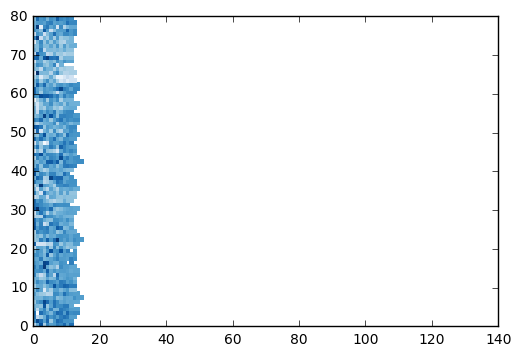

In [6]:
%matplotlib inline
eColi.showBacMap()

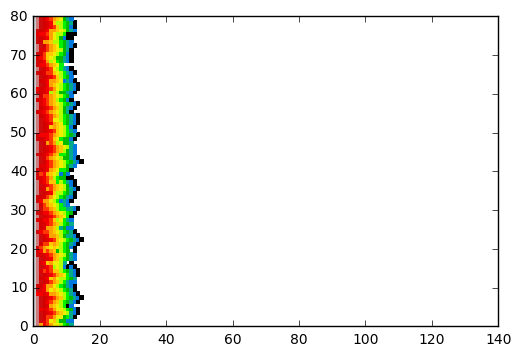

In [7]:
eColi.showAgeMap(pretty=True, )

In [25]:
eColi.saveVideo()


<IPython.core.display.Javascript object>


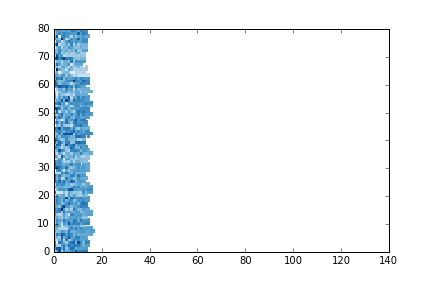

<IPython.core.display.Javascript object>


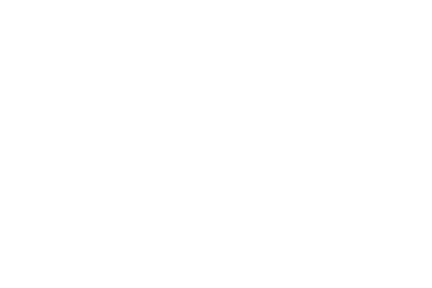

In [8]:
%matplotlib notebook
eColi.onlineSpreading(steps=2)